In [1]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=85734fcb9471555d30ec784e599a69d1cd9edcd2b0da95997d09b3e2c7ee5514
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


Total Distance using Kalman Filter: 5.2260879911745235 meters
Total Distance using Particle Filter: 5.226070755050147 meters
Total Distance using Savitzky-Golay Filter: 5.226113586462115 meters


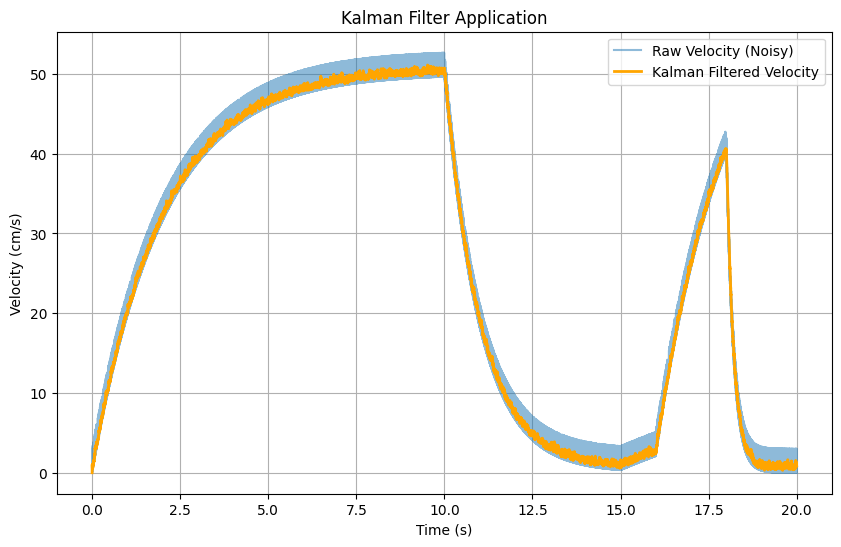

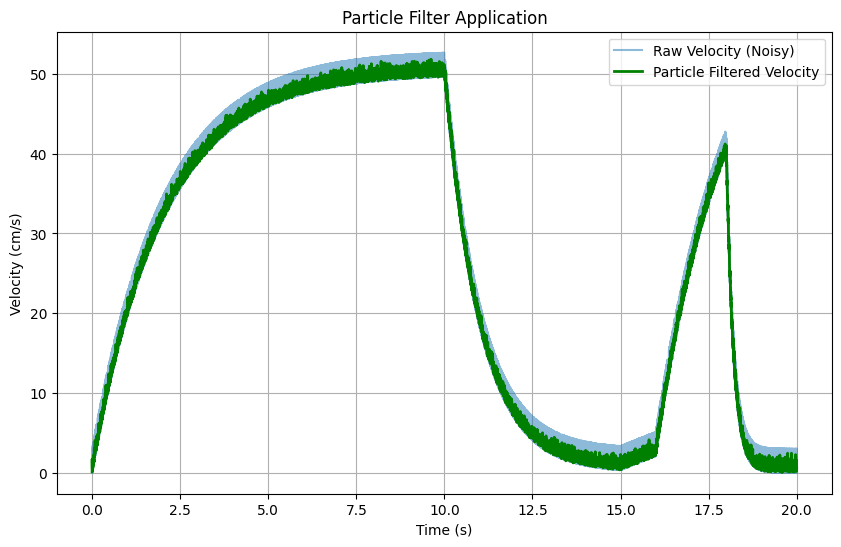

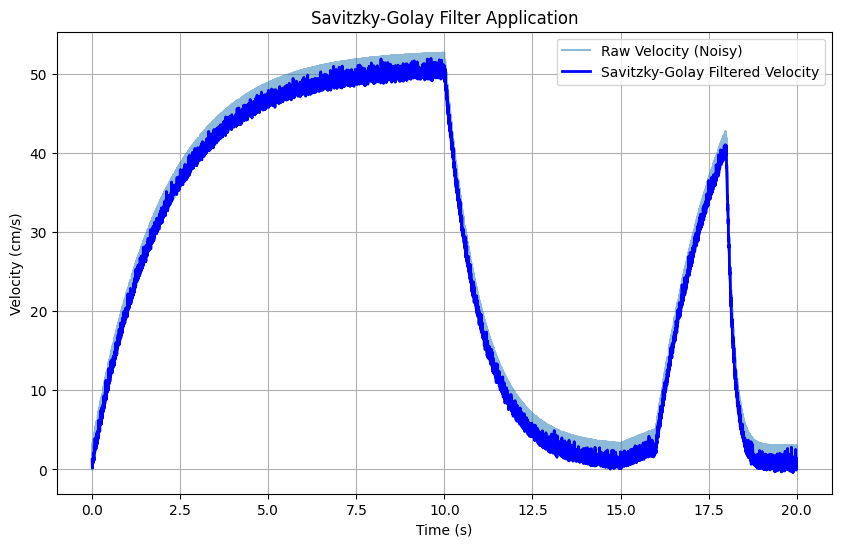

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from filterpy.monte_carlo import systematic_resample
from filterpy.kalman import KalmanFilter
import pandas as pd

# read data
data = pd.read_csv('Velocity_time.csv')

# Define Kalman Filter functions
def kalman_filter(data):
    # Initialize Kalman Filter
    kf = KalmanFilter(dim_x=1, dim_z=1)

    # Set initial state estimate and covariance
    kf.x = np.array([data['Vnoisy raw(cm/s)'][0]])  # Initial state (first noisy velocity)
    kf.P = np.eye(1) * 10  # Initial covariance
    kf.F = np.eye(1)  # State transition matrix (assuming constant velocity)
    kf.H = np.eye(1)  # Measurement matrix
    kf.R = np.eye(1) * 10  # Measurement noise covariance (adjust if needed)

    # Process noise covariance (Q), assuming small process noise
    process_variance = 0.1
    kf.Q = np.array([[process_variance]])

    # Apply Kalman Filter to smooth the noisy velocity data
    filtered_values_kf = []
    for z in data['Vnoisy raw(cm/s)']:
        kf.predict()  # Predict the next state
        kf.update(z)  # Update with the measurement
        filtered_values_kf.append(kf.x[0])

    return filtered_values_kf

# Define Particle Filter function
def particle_filter(data, N=1000, process_var=1.0, measurement_var=10.0):
    # Initialize particles and weights
    particles = np.random.uniform(-50, 50, size=N)  # Initial particle states
    weights = np.ones(N) / N  # Initial weights
    filtered_values_pf = []

    for z in data['Vnoisy raw(cm/s)']:
        # Predict
        particles += np.random.normal(0, np.sqrt(process_var), size=N)

        # Update weights based on measurement
        weights *= np.exp(-((particles - z) ** 2) / (2 * measurement_var))
        weights += 1.e-300  # Avoid division by zero
        weights /= sum(weights)  # Normalize

        # Resample if effective number of particles is too low
        if 1. / np.sum(weights ** 2) < N / 2:
            indices = systematic_resample(weights)
            particles = particles[indices]
            weights.fill(1.0 / N)

        # Estimate current state
        filtered_values_pf.append(np.sum(particles * weights))

    return filtered_values_pf

# Apply Kalman Filter to smooth the noisy velocity data
filtered_values_kf = kalman_filter(data)

# Apply Particle Filter
filtered_values_pf = particle_filter(data)

# Apply Savitzky-Golay Filter
window_length = 11  # Must be odd
polyorder = 2  # Degree of polynomial
filtered_values_sg = savgol_filter(data['Vnoisy raw(cm/s)'], window_length, polyorder)

# Add results to DataFrame
data['Vkf (cm/s)'] = filtered_values_kf
data['Vpf (cm/s)'] = filtered_values_pf
data['Vsg (cm/s)'] = filtered_values_sg

# Calculate total distances
velocity_kf = data['Vkf (cm/s)'] / 100  # Convert cm/s to m/s
distance_total_kf = np.trapz(velocity_kf, data['t (s)'])

velocity_pf = data['Vpf (cm/s)'] / 100  # Convert cm/s to m/s
distance_total_pf = np.trapz(velocity_pf, data['t (s)'])

velocity_sg = data['Vsg (cm/s)'] / 100  # Convert cm/s to m/s
distance_total_sg = np.trapz(velocity_sg, data['t (s)'])

print(f"Total Distance using Kalman Filter: {distance_total_kf} meters")
print(f"Total Distance using Particle Filter: {distance_total_pf} meters")
print(f"Total Distance using Savitzky-Golay Filter: {distance_total_sg} meters")

# Kalman Filter Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['t (s)'], data['Vnoisy raw(cm/s)'], label='Raw Velocity (Noisy)', alpha=0.5)
plt.plot(data['t (s)'], data['Vkf (cm/s)'], label='Kalman Filtered Velocity', linewidth=2, color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Kalman Filter Application')
plt.legend()
plt.grid()
plt.show()

# Particle Filter Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['t (s)'], data['Vnoisy raw(cm/s)'], label='Raw Velocity (Noisy)', alpha=0.5)
plt.plot(data['t (s)'], data['Vpf (cm/s)'], label='Particle Filtered Velocity', linewidth=2, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Particle Filter Application')
plt.legend()
plt.grid()
plt.show()

# Savitzky-Golay Filter Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['t (s)'], data['Vnoisy raw(cm/s)'], label='Raw Velocity (Noisy)', alpha=0.5)
plt.plot(data['t (s)'], data['Vsg (cm/s)'], label='Savitzky-Golay Filtered Velocity', linewidth=2, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Savitzky-Golay Filter Application')
plt.legend()
plt.grid()
plt.show()


In [3]:
# Calculate residual noise (difference between noisy data and filtered data)
residual_kf = data['Vnoisy raw(cm/s)'] - data['Vkf (cm/s)']
residual_pf = data['Vnoisy raw(cm/s)'] - data['Vpf (cm/s)']
residual_sg = data['Vnoisy raw(cm/s)'] - data['Vsg (cm/s)']

# Signal-to-Noise Ratio (SNR)
snr_kf = 10 * np.log10(np.var(data['Vkf (cm/s)']) / np.var(residual_kf))
snr_pf = 10 * np.log10(np.var(data['Vpf (cm/s)']) / np.var(residual_pf))
snr_sg = 10 * np.log10(np.var(data['Vsg (cm/s)']) / np.var(residual_sg))

print(f"SNR (Kalman Filter): {snr_kf:.2f} dB")
print(f"SNR (Particle Filter): {snr_pf:.2f} dB")
print(f"SNR (Savitzky-Golay Filter): {snr_sg:.2f} dB")

SNR (Kalman Filter): 25.47 dB
SNR (Particle Filter): 27.00 dB
SNR (Savitzky-Golay Filter): 25.96 dB
